In [1]:
from vtraj.ode import * 
from dataclasses import astuple, asdict,replace

import pandas as pd


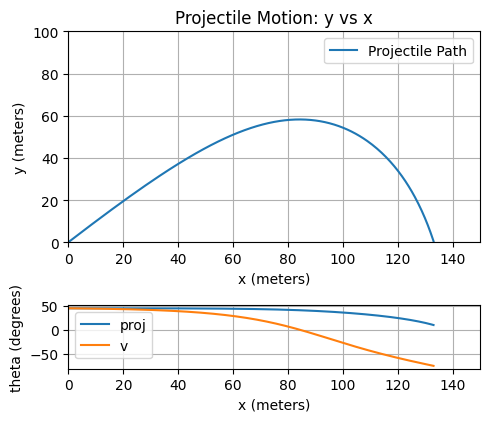

In [2]:
obs_params = Parameters(**{'Kp_theta': 0.1, 'C_d_1': 0.047, 'A_1': 0.045, 'C_d_2': 0.06, 'A_2': 0.08})
obs_ctx = Context( error=0, dt=1 / 30, params=obs_params)

v0 = 100
angle = 45

sol, df = throw(v0=v0, angle=angle, ctx=obs_ctx, dense_output=True)
plot_traj(df)

In [3]:
# "Observed" data
def mk_sol_df(sol, t = None):
    """Make a dataframe from the ODE solution"""
    if t is None:
        return pd.DataFrame(np.hstack([sol.t.reshape((-1,1)), sol.y.T]), columns="t x y theta vx vy".split())
    else:
        
        return pd.DataFrame(np.hstack([t.values.reshape((-1,1)), sol.sol(t).T]), columns="t x y theta vx vy".split())
        
obs = mk_sol_df(sol)
obs = obs[['t','x','y','theta']]

In [24]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, Bounds

# Objective function to minimize

def err(df1, df2):

    df1 = df1[['t','x','y', 'theta']]
    df2 = df2[['t','x','y', 'theta']]

    return np.sum((df1.y-df2.y)**2+(df1.x-df2.x)**2 + (df1.theta-df2.theta)**2)

def objective_function(params, ctx, obs ):

    sol, df = throw(v0=v0, angle=angle, ctx=replace(ctx, params=Parameters(*params)), dense_output=True)

    y = mk_sol_df(sol, obs['t'])
    
    return err(y, obs)

initial_params = np.array(astuple(obs_params))*1.4 # astuple(params)
#initial_params = [v0*1.5, angle*.75]
# Perform the optimization

# Define bounds to ensure all parameters are positive
bounds = Bounds([0] * len(initial_params), [np.inf] * len(initial_params))

# Perform the optimization
result = minimize(objective_function, initial_params, args=(obs_ctx, obs), bounds=bounds)

print("Orig Parameters:     ", np.array(astuple(obs_params)))
print("Initial Parameters:  ", initial_params)
print("Optimized parameters:", result.x)


Orig Parameters:      [0.1   0.047 0.045 0.06  0.08 ]
Initial Parameters:   [0.14   0.0658 0.063  0.084  0.112 ]
Optimized parameters: [0.09999822 0.0467153  0.04527423 0.05884161 0.08157494]


4.385089383439323e-09

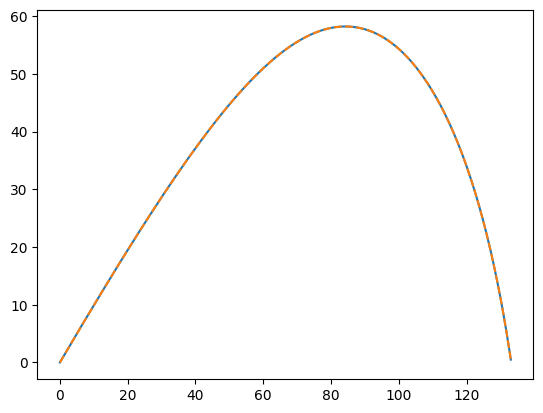

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)

ax.plot(obs.x, obs.y)

sol2, df = throw(v0=v0, angle=angle, ctx=replace(obs_ctx, params=Parameters(*result.x)), dense_output=True)

ax.plot(df.x, df.y, linestyle='--')

d1 = mk_sol_df(sol)
d2 = mk_sol_df(sol2,d1.t)

err(d2, d1)